# Bringing It All Together: Complete Economic Analysis

Time to combine everything we've got - FRED economic data, NBER recession dates, and consumer sentiment - into one comprehensive dataset. This is where we'll see the full picture of how different economic signals work together to predict downturns.

In [1]:
# Import notebook utilities
from notebook_utils import init_notebook, load_data, display_data_info, save_figure
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize notebook environment
init_notebook()

# Import from econ_downturn package
from econ_downturn import (
    engineer_features, normalize_data, apply_mda, create_discriminant_time_series,
    plot_indicator_with_recessions, plot_correlation_matrix,
    plot_feature_importance, plot_discriminant_time_series,
    plot_sentiment_vs_indicator, plot_sentiment_correlation_matrix
)

Initializing notebook environment...
✓ Added c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\src to Python path
✓ econ_downturn package imported successfully
✓ Notebook environment configured
✓ Environment variables loaded

Available data paths:
  fred_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred
  nber_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\nber
  processed_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed
  fred_all_indicators: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred\all_indicators.csv
  nber_recession_indicator: c:\Users\Admin\e

## Loading All Our Data Sources

Let's pull together data from all our sources - FRED economic indicators, NBER recession dates, and University of Michigan consumer sentiment. This gives us the complete picture.

In [2]:
# Load all data using the utility function
merged_data = load_data(use_cached=False)  # Force reload from original sources

# Display information about the dataset
display_data_info(merged_data)

Loading data from original sources...
2025-07-06 13:43:12,436 - econ_downturn.data.data_loader - INFO - Loaded FRED data with shape: (15510, 10)
2025-07-06 13:43:12,441 - econ_downturn.data.data_loader - INFO - Loaded NBER recession data with shape: (653, 1)
2025-07-06 13:43:12,446 - econ_downturn.data.data_loader - INFO - Loaded UMich data with shape: (653, 2)
2025-07-06 13:43:12,446 - econ_downturn.data.data_loader - INFO - Initialized merged dataset with 'FRED' data
2025-07-06 13:43:12,450 - econ_downturn.data.data_loader - INFO - Added 'NBER' data to merged dataset
2025-07-06 13:43:12,454 - econ_downturn.data.data_loader - INFO - Added 'UMICH' data to merged dataset
2025-07-06 13:43:12,454 - econ_downturn.data.data_loader - INFO - Merged dataset shape: (15657, 13)
2025-07-06 13:43:12,573 - econ_downturn.data.data_loader - INFO - Saved merged dataset to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\

,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,recession,SENTIMENT,INFLATION_EXPECTATION
count,218.000000,653.000000,653.000000,653.000000,11998.000000,2.839000e+03,653.000000,389.000000,653.000000,589.000000,653.000000,589.000000,557.000000
mean,12837.776711,6.110260,158.663954,4.910490,0.868401,3.733381e+05,74.982246,365237.385604,1435.917305,84.583531,0.128637,84.583531,3.590126
std,5217.489014,1.709394,73.783619,3.898737,0.925610,2.450608e+05,22.585732,138188.557313,410.165486,13.111529,0.335054,13.111529,1.625392
min,5299.672000,3.400000,37.900000,0.050000,-2.410000,1.890000e+05,36.388100,158647.000000,478.000000,50.000000,0.000000,50.000000,0.400000
25%,7760.008000,4.900000,100.100000,1.510000,0.190000,3.010000e+05,51.806000,264067.000000,1176.000000,74.300000,0.000000,74.300000,2.800000
50%,12216.346500,5.800000,159.800000,5.050000,0.830000,3.460000e+05,78.919700,349869.000000,1465.000000,88.200000,0.000000,88.200000,3.000000
75%,16937.626250,7.200000,219.035000,6.890000,1.500000,4.020000e+05,97.606000,443117.000000,1698.000000,94.200000,0.000000,94.200000,3.500000
max,23223.906000,14.800000,313.140000,19.100000,2.910000,6.137000e+06,104.103800,692635.000000,2494.000000,112.000000,1.000000,112.000000,10.400000



Missing Values:


,Missing Values,Percentage
GDP,15439,98.607652
RETAIL_SALES,15268,97.515488
INFLATION_EXPECTATION,15100,96.442486
SENTIMENT,15068,96.238104
CONSUMER_SENTIMENT,15068,96.238104
INDUSTRIAL_PROD,15004,95.829342
FED_FUNDS,15004,95.829342
CPI,15004,95.829342
UNEMPLOYMENT,15004,95.829342
recession,15004,95.829342


## Exploring Consumer Sentiment Patterns

This step will analyze consumer sentiment in relation to our recession flagging and our features. We will use visuals to surface any potential predictive relationships. This is a supplemental analysis that highlights consumer sentiment as a warning method for recession. In addition, it justifies the metric's inclusion in further modeling. Three functions are used:

1. The plot_indicator_with_recessions() function will visualize the sentiment index over time. It also overlays recession shading to highlight any lead-lag behavior.

2. The plot_sentiment_vs_indicator() function is used twice here. It is used to compare sentiment vs. unemployment rate and GDP. These are considered our two most key features, and deserve special highlighting in our analysis.

3. plot_sentiment_correlation_matrix() function is the overall visual used for comparisons. It compares how closely sentiment relates to our economic indicators, showing which ones move most with it.

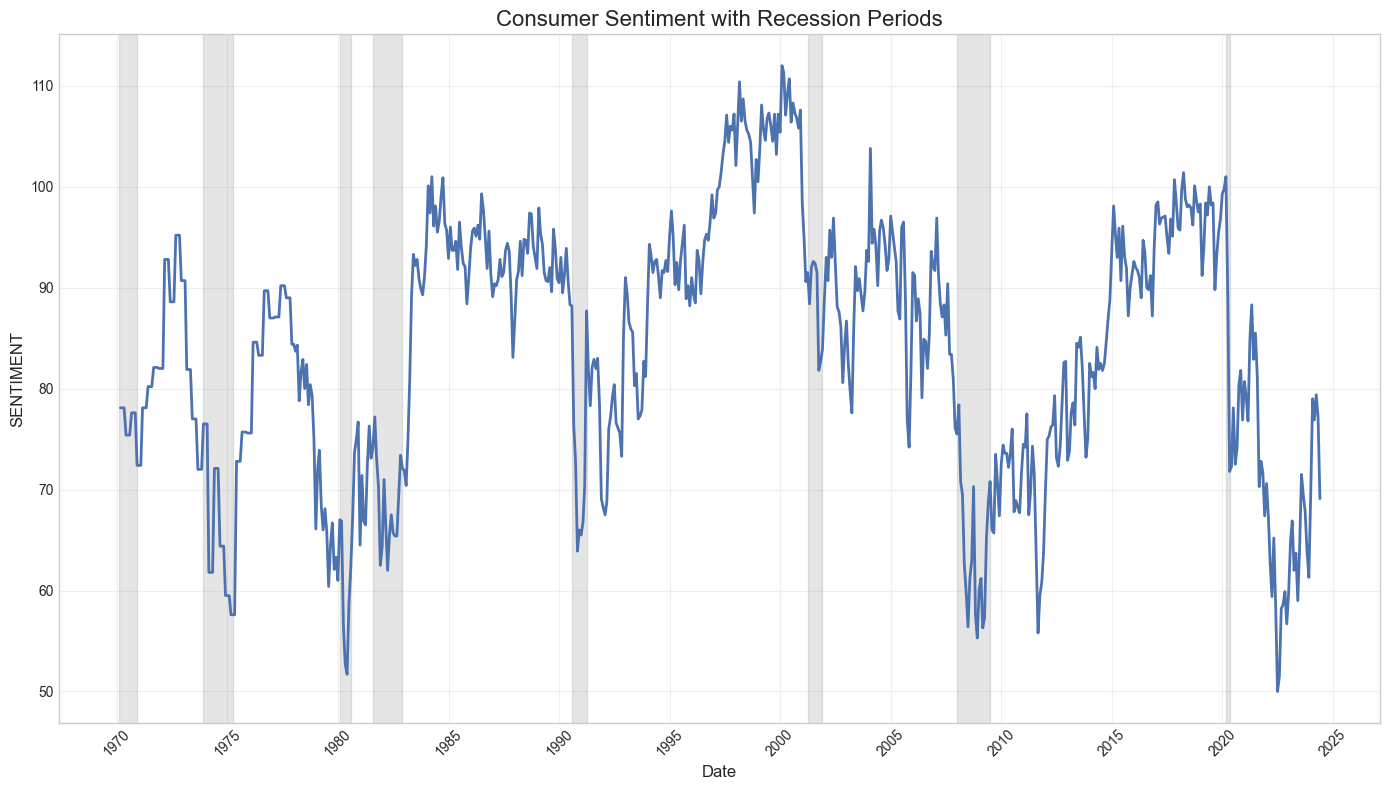

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\consumer_sentiment.png


In [3]:
# Plot consumer sentiment over time with recession periods
fig = plot_indicator_with_recessions(
    merged_data, 
    'SENTIMENT', 
    title='Consumer Sentiment with Recession Periods'
)
plt.show()
save_figure(fig, "consumer_sentiment.png")

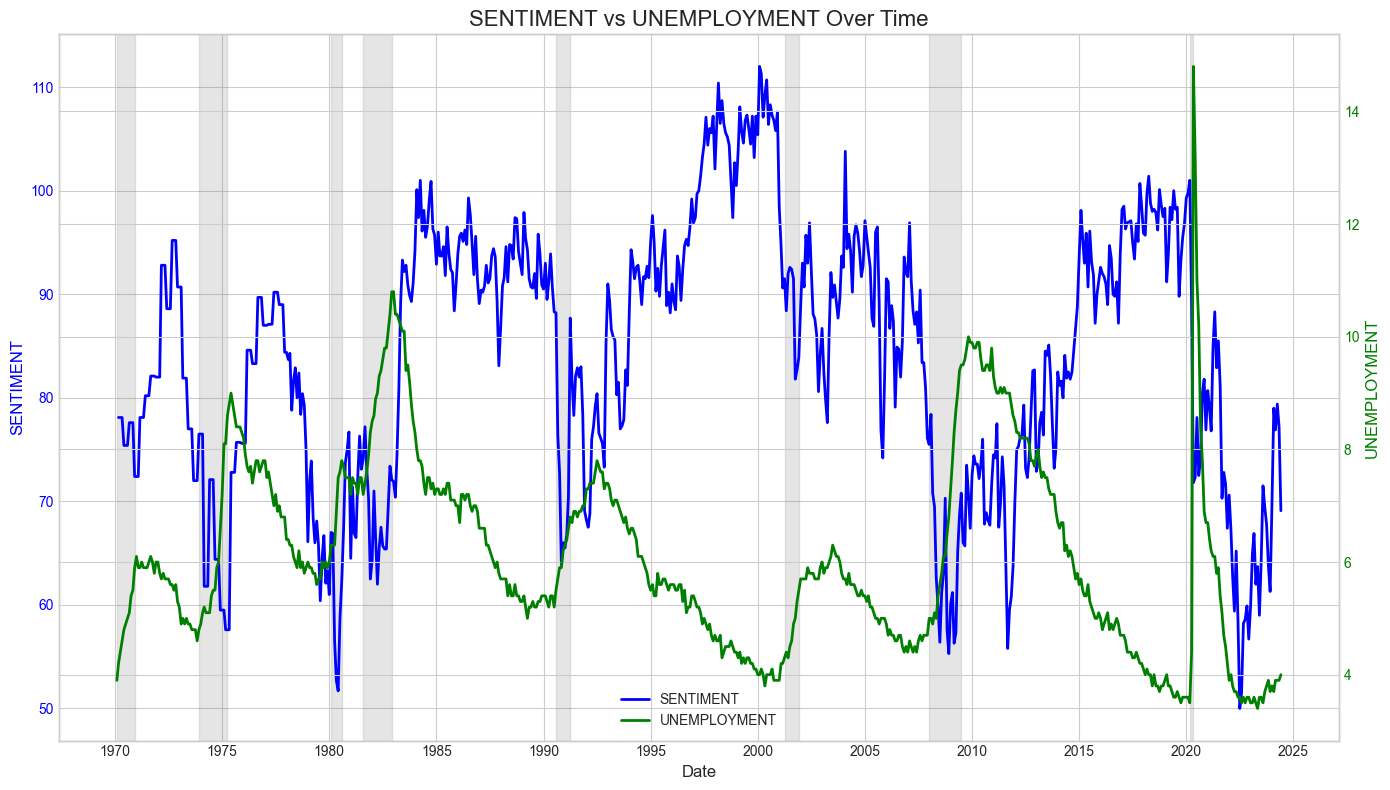

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\sentiment_vs_unemployment.png


In [4]:
# Plot consumer sentiment vs unemployment rate
fig = plot_sentiment_vs_indicator(
    merged_data,
    sentiment_col='SENTIMENT',
    indicator_col='UNEMPLOYMENT'
)
plt.show()
save_figure(fig, "sentiment_vs_unemployment.png")

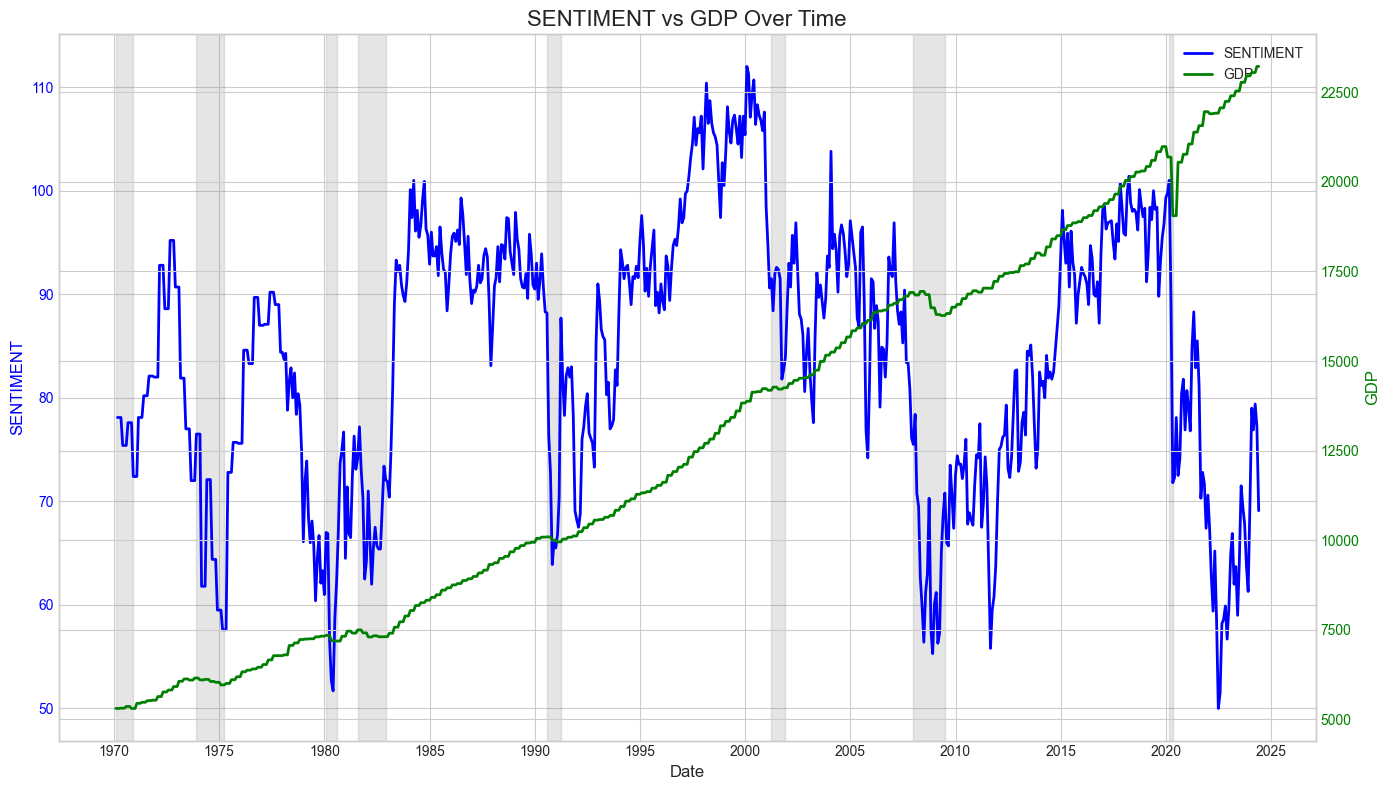

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\sentiment_vs_gdp.png


In [5]:
# Plot consumer sentiment vs GDP growth
fig = plot_sentiment_vs_indicator(
    merged_data,
    sentiment_col='SENTIMENT',
    indicator_col='GDP'
)
plt.show()
save_figure(fig, "sentiment_vs_gdp.png")

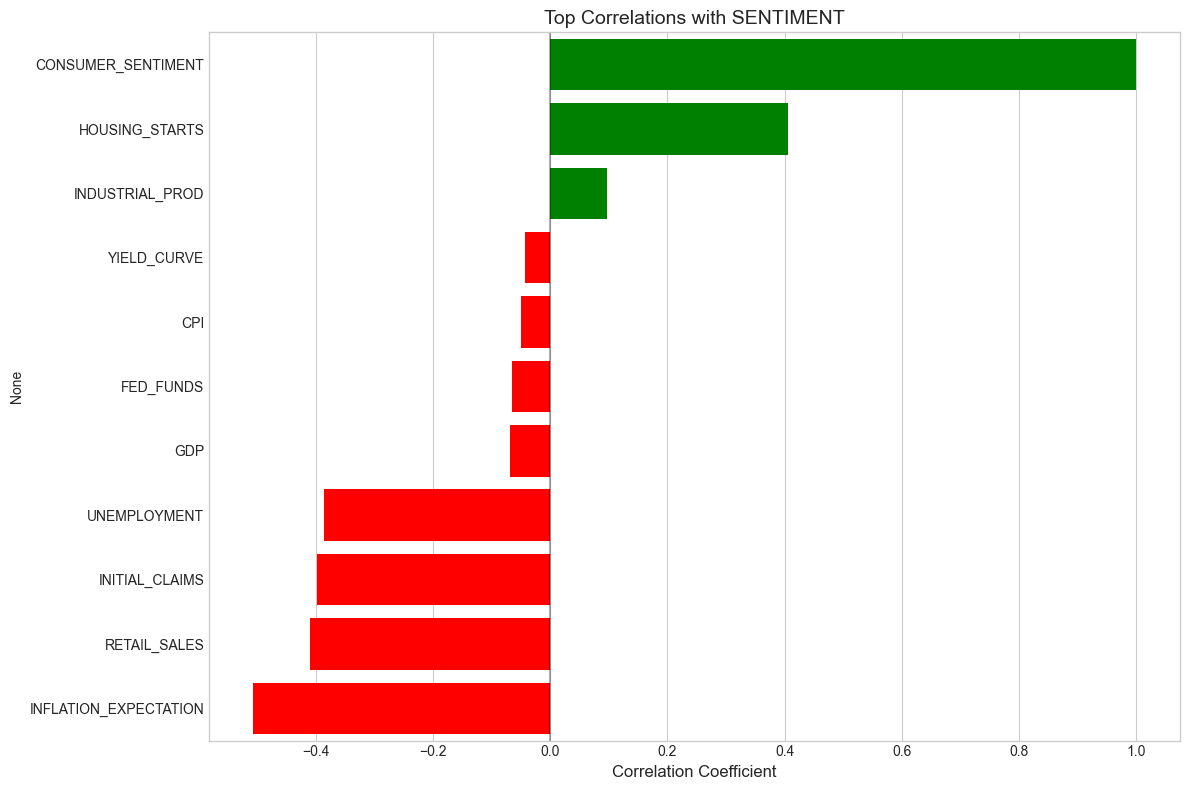

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\sentiment_correlation_matrix.png


In [6]:
# Plot correlations between consumer sentiment and economic indicators
fig = plot_sentiment_correlation_matrix(
    merged_data,
    sentiment_cols=['SENTIMENT'],
    top_n=10
)
plt.show()
save_figure(fig, "sentiment_correlation_matrix.png")

## Engineering Features with Sentiment Data

This step transforms the combined dataset to include time-based dynamics and interactions. This is further experimentation on how timing with lagging relate to our recession assessments.

1. The engineer_features() function adds new columns that will capture prior values (lags), percent change, and rolling statistics for all relevant variables (including sentiment). 

2. The number of features and the shape of the resulting dataset are printed. This helps to verify successful transformation and expansion of the dataset features.

3. The final dataset we engineered is saved for future re-use.

In [7]:
# Handle missing values and create lag variables
data_with_features = engineer_features(merged_data)

print(f"Data with features shape: {data_with_features.shape}")
print(f"Number of features: {data_with_features.shape[1]}")

# Save the dataset with features
from econ_downturn import get_data_paths
data_paths = get_data_paths()
output_dir = data_paths['processed_dir']
os.makedirs(output_dir, exist_ok=True)
features_path = os.path.join(output_dir, 'data_with_features_and_sentiment.csv')
data_with_features.to_csv(features_path)
print(f"Saved dataset with features to {features_path}")

2025-07-06 13:43:14,366 - econ_downturn.features.feature_engineering - WARNING - There are still 15004 missing values after handling
2025-07-06 13:43:14,375 - econ_downturn.features.feature_engineering - INFO - Resampled data to M frequency, new shape: (653, 13)
2025-07-06 13:43:14,384 - econ_downturn.features.feature_engineering - INFO - Created lag variables with periods [1, 3, 6, 12], new shape: (653, 61)
2025-07-06 13:43:14,397 - econ_downturn.features.feature_engineering - INFO - Calculated rate of change with periods [1, 3, 12], new shape: (653, 97)
2025-07-06 13:43:14,424 - econ_downturn.features.feature_engineering - INFO - Dropped rows with missing values, new shape: (635, 97)
2025-07-06 13:43:14,425 - econ_downturn.features.feature_engineering - INFO - Completed feature engineering, final shape: (635, 97)
Data with features shape: (635, 97)
Number of features: 97
Saved dataset with features to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downtu

## Normalizing for Fair Comparison

This step standardizes all our features onto a common scale, to sensure they contribute equally to the model.

1. normalize_data() applies the normalized scale. It scales all numerical features so they have the same unit of measurement. Normally, this is a zeroed mean and unity variance. This allows the model to treat each of the features fairly regardless of original magnitude.

2. We print the dataset's shape to confirm that the number of rows and columns has stayed consistent after normalization. This is a buffer step to make sure no unintended changes were left in our process.

In [8]:
# Normalize the data
data_normalized, scaler = normalize_data(data_with_features)

print(f"Normalized data shape: {data_normalized.shape}")

# Save the normalized dataset
normalized_path = os.path.join(output_dir, 'data_normalized_with_sentiment.csv')
data_normalized.to_csv(normalized_path)
print(f"Saved normalized dataset to {normalized_path}")

2025-07-06 13:43:14,496 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (635, 97)
Normalized data shape: (635, 97)
Saved normalized dataset to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\data_normalized_with_sentiment.csv


## Testing Our Enhanced Model

This is the testing phase that checks whether adding consumer sentiment from our UMICH dataset improves the ability of our model to assess recession risk.

1. First we seperate our features and target indicators.

2. We run our MDA model using our previously defined apply_mda function. As previously stated, this returns accuracy, cross-validation scores, confusion matrix, classification report, and feature importances.

3. Final performance results are printed. This is to show how well the model distinguishes between recessionary and non-recessionary periods, with an emphasis on precision, recall, and overall accuracy.

4. Our important features are visualized and stored. They are plotted alongside the MDA-generated discriminant score over time to show how well the model detects recession phases.

In [9]:
# Separate features and target
X = data_normalized.drop(columns=['recession'])
y = data_normalized['recession']

# Apply MDA
mda_results = apply_mda(X, y)

# Print model performance metrics
print(f"Accuracy: {mda_results['accuracy']:.4f}")
print("\nConfusion Matrix:")
print(mda_results['conf_matrix'])
print("\nClassification Report:")
print(mda_results['class_report'])
print(f"\nCross-Validation Scores: {mda_results['cv_scores']}")
print(f"Mean CV Score: {mda_results['cv_scores'].mean():.4f}")

2025-07-06 13:43:14,586 - econ_downturn.models.mda - INFO - Training set shape: (444, 96), Testing set shape: (191, 96)
2025-07-06 13:43:14,608 - econ_downturn.models.mda - INFO - Accuracy: 0.9581
2025-07-06 13:43:14,609 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[165   4]
 [  4  18]]
2025-07-06 13:43:14,609 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       169
         1.0       0.82      0.82      0.82        22

    accuracy                           0.96       191
   macro avg       0.90      0.90      0.90       191
weighted avg       0.96      0.96      0.96       191

2025-07-06 13:43:14,676 - econ_downturn.models.mda - INFO - Cross-Validation Scores: [0.96062992 0.96850394 0.96850394 0.93700787 0.99212598]
2025-07-06 13:43:14,677 - econ_downturn.models.mda - INFO - Mean CV Score: 0.9654
2025-07-06 13:43:14,678 - econ_downturn.models.mda - INFO - Top 5 Mo

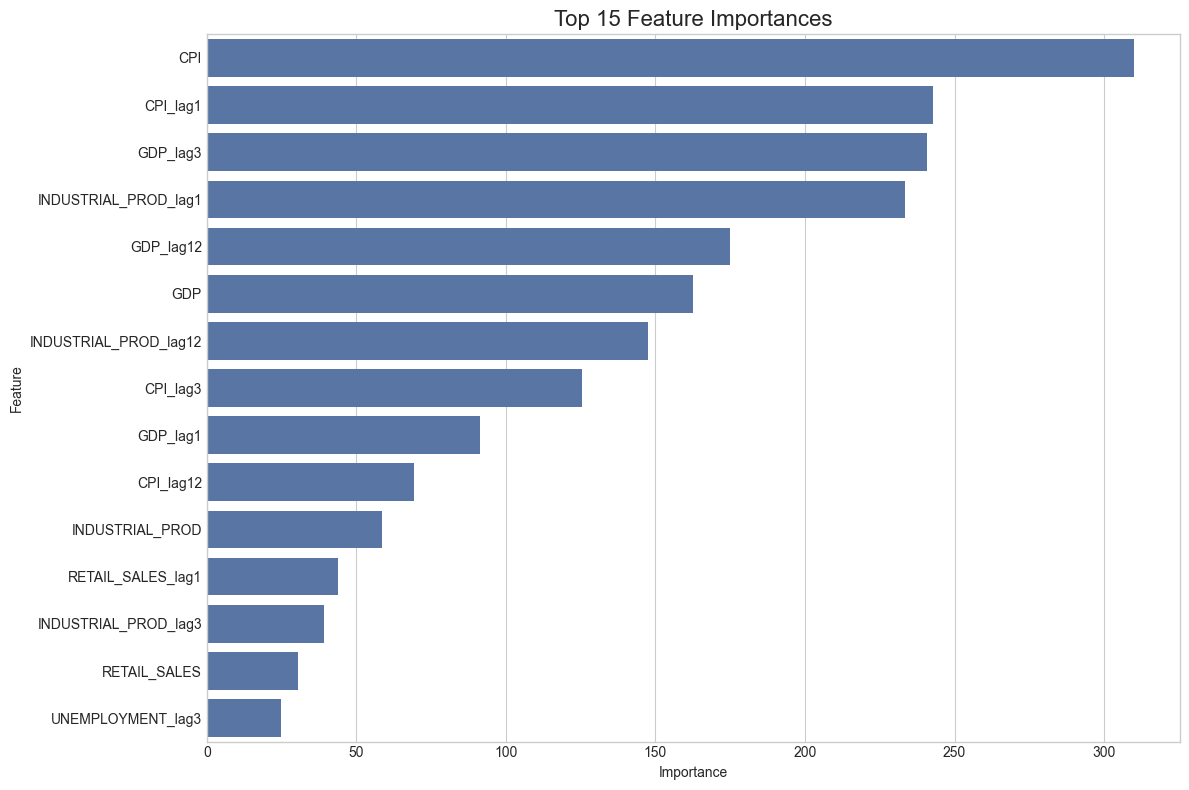

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\feature_importance_with_sentiment.png


In [10]:
# Plot feature importances
if mda_results['feature_importance'] is not None:
    fig = plot_feature_importance(mda_results['feature_importance'])
    plt.show()
    save_figure(fig, "feature_importance_with_sentiment.png")

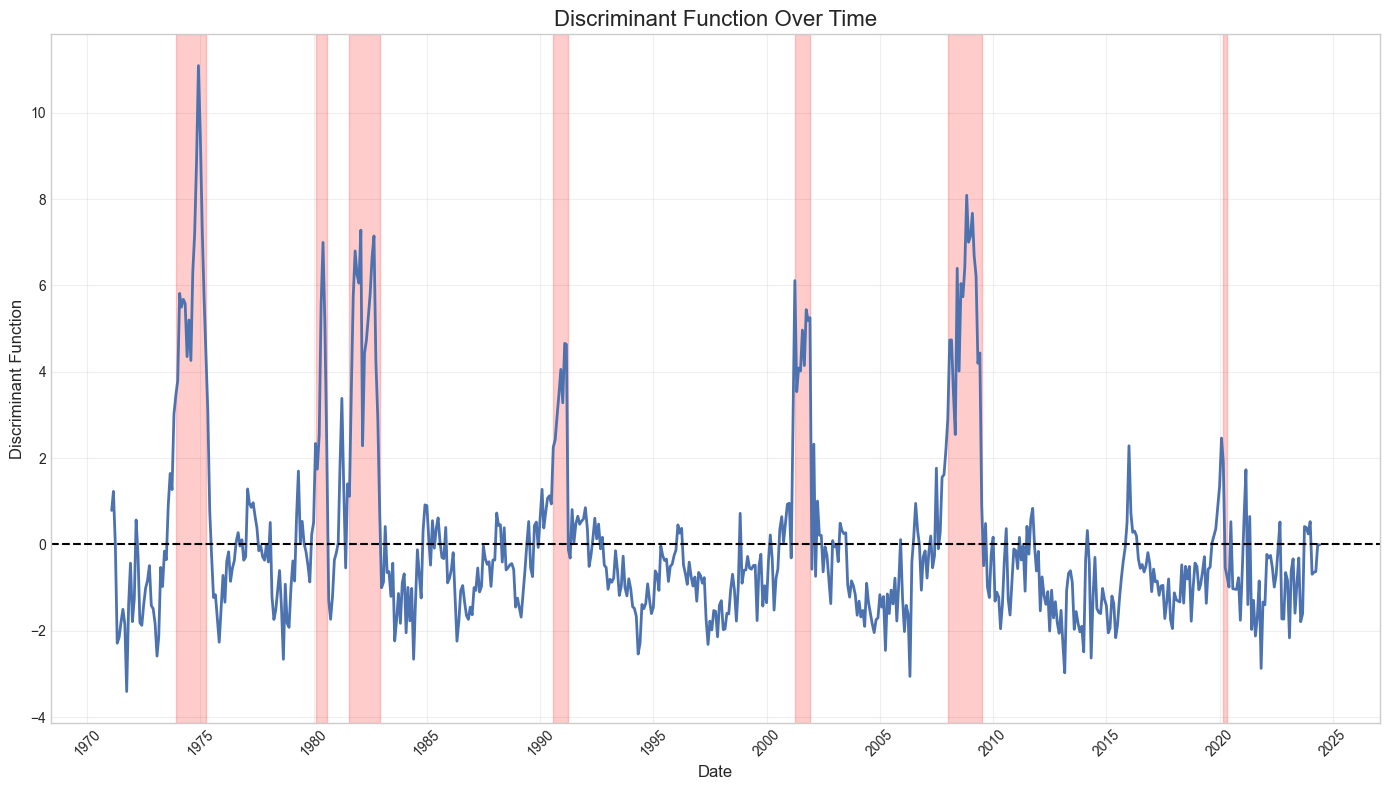

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\discriminant_time_series_with_sentiment.png


In [11]:
# Create and plot discriminant time series
discriminant_df = create_discriminant_time_series(
    mda_results['model'], X, y
)

fig = plot_discriminant_time_series(discriminant_df)
plt.show()
save_figure(fig, "discriminant_time_series_with_sentiment.png")